In [1]:
import root_pandas as rp
import pandas as pd
import ROOT
from ROOT import TVector3, TRandom, TMath
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Welcome to JupyROOT 6.18/00


In [2]:
# First Load the raw data

# The data is stored in 100 root files each containing 10k electron recoil simulations
files_e = []
for i in range(2):
    files_e+= ['./raw_data/he_co2_50keV_'+str(i)+'/he_co2_50keV_'+str(i)+'.root']
    
df = rp.read_root(files_e)

df.columns

Index(['event_number', 'npoints', 'x', 'y', 'z', 't', 'q'], dtype='object')

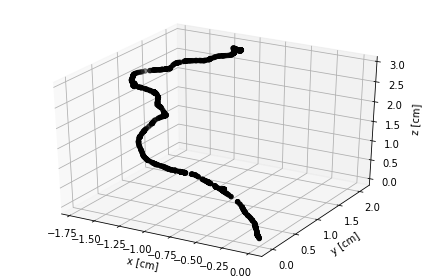

In [3]:
#Visualize raw simulations 

#select recoil index and obtain data
i = 10
x = df.iloc[i]['x']
y = df.iloc[i]['y']
z = df.iloc[i]['z']


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')

#recoil starts at origin, zoom into that if interested
#ax.axes.set_xlim3d(-1,1) 
#ax.axes.set_ylim3d(-1,1) 
#ax.axes.set_zlim3d(-1,1) 


plt.tight_layout()
ax.scatter3D(x, y, z, c='k', marker='o')
# Add red line for true direction (z direction)
#ax.plot3D([0,0], [0,0], [0,1], c='r')

In [20]:
# Define tools to rotate track randomly

def rotate_track(track, to_dir):

    for charge in track:

        charge.RotateY(-(0.5*TMath.Pi()-to_dir.Theta()))
        charge.RotateZ(to_dir.Phi())


def random_three_vector():

    """

    Generates a random 3D unit vector (direction) with a uniform spherical distribution
    Algo from http://stackoverflow.com/questions/5408276/python-uniform-spherical-distribution

    """

    phi = np.random.uniform()*2*np.pi

    costheta = 2.0*np.random.uniform()-1.0
    theta = TMath.ACos( costheta )

    x = TMath.Sin( theta) * TMath.Cos( phi )
    y = TMath.Sin( theta) * TMath.Sin( phi )
    z = TMath.Cos( theta )

    return TVector3(x,y,z)

In [21]:
# Total sigma [cm] used for diffusion
sigma = 466.0 * float(1e-4)

In [22]:
# Determine random direction to rotate to
to_dir = random_three_vector()


In [23]:
# make lists for transformed data
x_new = []
y_new = []
z_new = []
    
    
for x,y,z in zip(df.iloc[i]['x'],df.iloc[i]['y'],df.iloc[i]['z']):
        
    # Extract vector for charge position
    charge = TVector3(x,y,z)
        
    # Rotate the charge
    charge.RotateY(to_dir.Theta())
    charge.RotateZ(to_dir.Phi())
        
    # Add diffusion
    charge += TVector3(sigma* np.random.normal(),sigma* np.random.normal(),sigma* np.random.normal())
        
    x_new += [charge[0]]
    y_new += [charge[1]]
    z_new += [charge[2]]

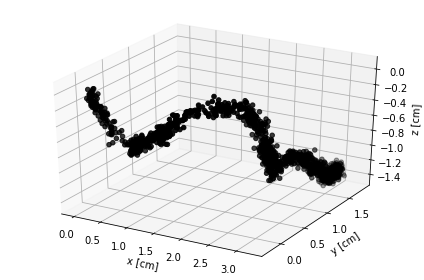

In [25]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')

#recoil starts at origin, zoom into that if interested
#ax.axes.set_xlim3d(-1,1) 
#ax.axes.set_ylim3d(-1,1) 
#ax.axes.set_zlim3d(-1,1) 


plt.tight_layout()
ax.scatter3D(x_new, y_new, z_new, c='k', marker='o')
# Add red line for true direction (z direction)
#ax.plot3D([0,to_dir[0]], [0,to_dir[1]], [0,to_dir[2]], c='r')

In [27]:
# shift to data mean
x_final = []
y_final = []
z_final = []


mean_dir = TVector3(np.mean(x_new),np.mean(y_new),np.mean(z_new))

for x,y,z in zip(x_new,y_new,z_new):
    charge = TVector3(x,y,z)
    charge -= mean_dir    
    x_final += [charge[0]]
    y_final += [charge[1]]
    z_final += [charge[2]]

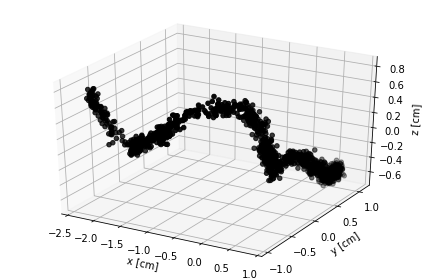

In [29]:
# plot full recoil
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')




plt.tight_layout()
ax.scatter3D(x_final, y_final, z_final, c='k', marker='o')

# Show position of origin
#ax.scatter3D([0], [0], [0], c='r', marker='o',s=100)

In [30]:
# Pixelize the recoil

# x/y/z length being kept in cm in cm
eff_l = 2.5

# voxel size in cm
vox_l = 0.1


#number of pixels along 1 dim
Npix = round(eff_l*2/vox_l) 


# create grid for image
grid = np.zeros((Npix,Npix,Npix,1))

missing = 0

# loop through recoil
for x,y,z in zip(x_final,y_final,z_final):
    
    #obtain index corresponiding to position
    x_ind = int((x+eff_l)/vox_l)
    y_ind = int((y+eff_l)/vox_l)
    z_ind = int((z+eff_l)/vox_l)
    
    if 0<=x_ind<Npix and 0<=y_ind<Npix and 0<=y_ind<Npix:
        grid[x_ind,y_ind,z_ind,0] += 1
        
    else:
        missing += 1
        

print("Amount of missing charge: ", missing) 

Amount of missing charge:  0


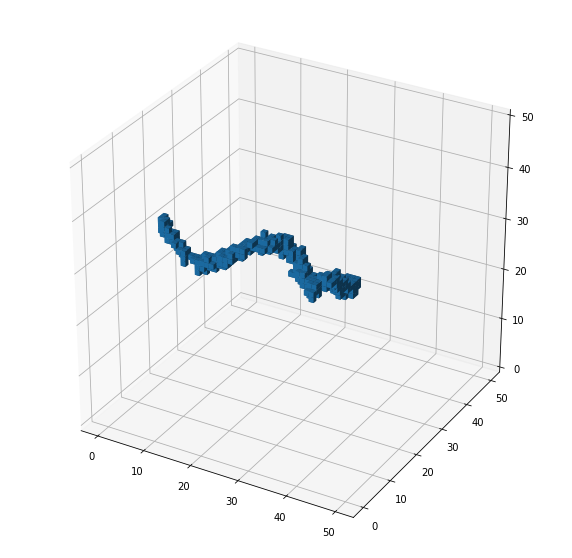

In [31]:
# Show recoil pixelized recoil

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

#w=plt.axis('off')
e=ax.voxels(grid[:,:,:,0])